In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from env import get_db_url
import wrangle
from statistics import stdev
from sklearn.model_selection import train_test_split
from itertools import combinations, product, permutations
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

### Acquire
- Zillow data was pulled from Codeup's database utilizing a SQL query for single family homes with transcations in 2017.
- Looking at the dataset in MySQLWorkbench, many columns were missing data or had erroneous information.
- Information gathered was:
    - taxvaluedollarcnt(Tax_Appraised_Value - **target**)
    - bedroomcnt(Number_of_Bedrooms)
    - bathroomcnt(Number_of_Bathrooms)
    - calculatedfinishedsquarefeet(Square_Feet)
    - lotsizesquarefeet(Lot_Size)
    - yearbuilt(Year_Built)
    - fips(County_Code)
    - taxamount(Tax_Assessed)



In [2]:
df = wrangle.get_zillow_data()

### Prepare
  
   - **Data cleaning:**
   - dropped nulls, converted fips(County_Code) to counties, converted floats to integers
   
   - **Parameters of home values**
       - The data has been updated to include only home with greater than 1 bed, 1 bath, and a minimum of 120 sq. ft.
       - Approximately 8% of data was dropped to exclude outliers.
           - Values are:
               - 7 Beds
               - 7.5 Baths
               - 10,000 or less sq. feet
               - 20,000 or less sq. feet (lot size)
               - Greater than 50K or less than 3.5M in appraised value
   

In [3]:
df = wrangle.prepare_zillow_data(df)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [4]:
df = wrangle.handle_outliers(df)

### Explore
- Questions to answer:
    - Do the number of bedrooms correlate to the appraised value?
    - Do the number of bathrooms correlate to the appraised value?
    - Does square feet impact the appraised value?
    - Does lot size impact the appraised value?
    - Does the county impact the appraised value?

In [5]:
# split into train, validate, test before exploration
train, validate, test = wrangle.split_zillow_data(df)

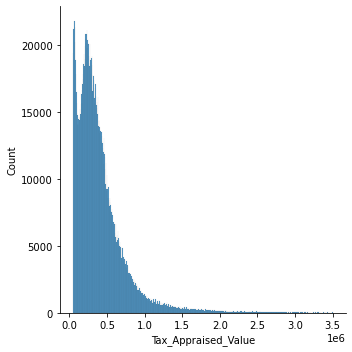

In [6]:
# visualize distibution of target variable 
sns.displot(df.Tax_Appraised_Value)
plt.show()

### Number of Bedrooms to Appraised Value
- Null Hypothesis: There is no linear correlation between the number of bedrooms and the appraised value of the home.
- Alternative Hypothesis: There is a linear correlation between the number of bedrooms and the appraised value of the home.

In [7]:
alpha=.05
corr, p = stats.pearsonr(train.Number_of_Bedrooms, train.Tax_Appraised_Value)
p < alpha, corr

(True, 0.24309351177692087)

**Reject the null hypothesis that there is no linear correlation. Correlation between the number of bedrooms and appraised value is statistically significant, although weak, with an r value at .24**

### Number of Bathrooms to Appraised Value
- Null Hypothesis: There is no linear correlation between the number of bathrooms and the appraised value of the home.
- Alternative Hypothesis: There is a linear correlation between the number of bathrooms and the appraised value of the home.

In [8]:
alpha=.05
corr, p = stats.pearsonr(train.Number_of_Bathrooms, train.Tax_Appraised_Value)
p < alpha, corr

(True, 0.4956479170148407)

**Reject the null hypothesis that there is no linear correlation. Correlation between the number of bathrooms and appraised value is statistically significant, with an r value at .50**

### Square Feet to Appraised Value

- Null Hypothesis: There is no linear correlation between square feet and the appraised value of the home.
- Alternative Hypothesis: There is a linear correlation between square feet and the appraised value of the home.

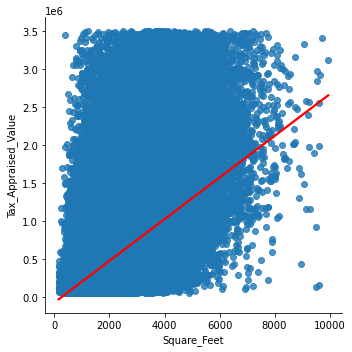

In [9]:
sns.lmplot(data=train,x='Square_Feet',y='Tax_Appraised_Value',line_kws={'color':'red'})
plt.show()

In [10]:
alpha=.05
corr, p = stats.pearsonr(train.Square_Feet, train.Tax_Appraised_Value)
p < alpha, corr

(True, 0.574861570891157)

**Reject the null hypothesis that there is no linear correlation. Correlation between square feet and appraised value is statistically significant, with an r value at .57**

### Lot Size to Appraised Value
- Null Hypothesis: There is no linear correlation between lot size and the appraised value of the home.
- Alternative Hypothesis: There is a linear correlation between lot size and the appraised value of the home.

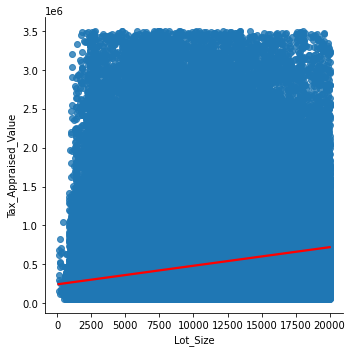

In [11]:
sns.lmplot(data=train,x='Lot_Size',y='Tax_Appraised_Value',line_kws={'color':'red'})
plt.show()

In [12]:
alpha=.05
corr, p = stats.pearsonr(train.Lot_Size, train.Tax_Appraised_Value)
p < alpha, corr

(True, 0.19381759762843995)

**Reject the null hypothesis that there is no linear correlation. Correlation between lot size and appraised value is statistically significant, however, correlation is weak with an r value of .19**

### County to Appraised Value
- Null Hypothesis: There is no statistical significance between the appraised values in LA, Orange, or Ventura Counties.
- Alternate Hypothesis: There is a statistical significance between the appraised values in LA, Orange, or Ventura Counties.

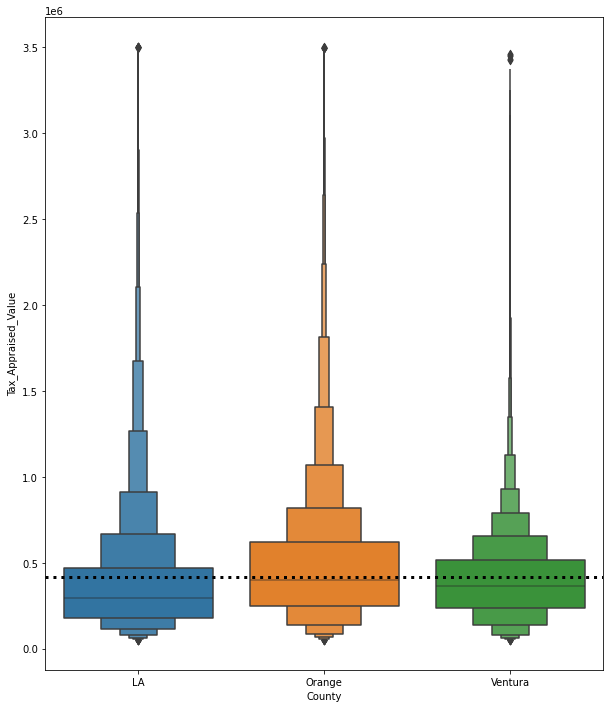

In [13]:
plt.figure(figsize=(10,12))
sns.boxenplot(data=train, y=train.Tax_Appraised_Value, x=train.County)
plt.axhline(train.Tax_Appraised_Value.mean(),ls= ':', color = 'black', linewidth=3)
plt.show()

In [14]:
LA,Orange,Ventura = wrangle.create_county_db(df)

In [15]:
f, p = stats.f_oneway(LA.Tax_Appraised_Value,Orange.Tax_Appraised_Value,Ventura.Tax_Appraised_Value)
p < alpha

True

**Reject the null hypothesis that there is no statistical significance between the three counties.**

### Modeling

In [16]:
# scale the split datasets with MinMax scaler
train_scaled, validate_scaled, test_scaled = wrangle.scale_data(train,validate,test)

In [105]:
# set X and y values fro train, validate, test datasets
X_train = train_scaled.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_train = train_scaled['Tax_Appraised_Value']

X_validate = validate_scaled.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_validate = validate_scaled['Tax_Appraised_Value']

X_test = test_scaled.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_test = test_scaled['Tax_Appraised_Value']

#### Establish a baseline

In [106]:
# create df for y_train and y_validate
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [107]:
# add the mean value of the target variable
y_train['TAV_pred_mean'] = round(train.Tax_Appraised_Value.mean(),2)
y_validate['TAV_pred_mean'] = round(train.Tax_Appraised_Value.mean(),2)

In [108]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  362827.44 
Validate/Out-of-Sample:  362673.71


**Takeaways:** 
- Will utilize the mean for the baseline as is performs better than the median.
- Out-of-sample model performs better than the in-sample model.


### Ordinary Least Squares Model

**Features used in modeling: Number of Bedrooms, Number of Bathrooms, Square Feet**

In [109]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [110]:
# create the model
lm = LinearRegression(normalize=True)

In [111]:
# fit the model
lm.fit(X_train, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [112]:
# train the model
y_train['TAV_pred_lm'] = lm.predict(X_train)
y_validate['TAV_pred_lm'] = lm.predict(X_validate)

In [113]:
# evaluate RMSE
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_lm)**(1/2)
print('RMSE OLS in Sample: ', round(rmse_train,2))
print('RMSE OLS Out of Sample: ', round(rmse_validate,2))

RMSE OLS in Sample:  291210.61
RMSE OLS Out of Sample:  290832.37


**Beats baseline by 71616.83 on in-sample data and by 71841.34 on out-of-sample data.**

### Tweedie Regressor Model

In [117]:
# create the model
glm = TweedieRegressor(power=0, alpha=1)

In [118]:
# fit the model
glm.fit(X_train, y_train.Tax_Appraised_Value)

TweedieRegressor(alpha=1, power=0)

In [119]:
# train the model
y_train['TAV_pred_glm'] = glm.predict(X_train)
y_validate['TAV_pred_glm'] = glm.predict(X_validate)

In [120]:
# evaluate RMSE
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_glm)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_glm)**(1/2)
print('RMSE  Tweedie in Sample: ', round(rmse_train,2))
print('RMSE Tweedie Out of Sample: ', round(rmse_validate,2))

RMSE  Tweedie in Sample:  360172.51
RMSE Tweedie Out of Sample:  360013.87


**Tweedie Regressor Model performs slightly better than baseline but worse than OLS**

### Polynomial Regression Model

In [121]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [122]:
# create the model 
lm2 = LinearRegression(normalize=True)

In [123]:
# fit the model 
lm2.fit(X_train_degree2, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [124]:
# train the model
y_train['TAV_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['TAV_pred_lm2'] = lm2.predict(X_validate_degree2)

In [69]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm2)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_lm2)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))
print('RMSE Out of Sample: ', round(rmse_validate,2))

RMSE in Sample:  286186.0
RMSE Out of Sample:  285811.24


**Polynomial Regression Model performs better than baseline AND OLS model. Will move forward with Polynomial Model.**

### Polynomial Regression Model per County

In [125]:
# call the functions to split scaled train, validate, test datasets into counties
LA_scaled_TR, Orange_scaled_TR, Ventura_scaled_TR = wrangle.train_county(train_scaled)
LA_scaled_V, Orange_scaled_V, Ventura_scaled_V = wrangle.validate_county(validate_scaled)
LA_scaled_T, Orange_scaled_T, Ventura_scaled_T = wrangle.test_county(test_scaled)

### LA County

In [126]:
X_train = LA_scaled_TR.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_train = LA_scaled_TR['Tax_Appraised_Value']

X_validate = LA_scaled_V.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_validate = LA_scaled_V['Tax_Appraised_Value']

X_test = LA_scaled_T.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_test = LA_scaled_T['Tax_Appraised_Value']

In [127]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [128]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [129]:
# create the model 
lm_LA = LinearRegression(normalize=True)

In [130]:
# fit the model 
lm_LA.fit(X_train_degree2, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [131]:
y_train['TAV_pred_lm_LA'] = lm_LA.predict(X_train_degree2)
y_validate['TAV_pred_lm_LA'] = lm_LA.predict(X_validate_degree2)

In [132]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_LA)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_lm_LA)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))
print('RMSE Out of Sample: ', round(rmse_validate,2))

RMSE in Sample:  291502.55
RMSE Out of Sample:  289529.1


**Beats baseline by 71324.89 on in-sample data and by 73144.61 on out-of-sample data.**

### Orange County

In [133]:
X_train = Orange_scaled_TR.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_train = Orange_scaled_TR['Tax_Appraised_Value']

X_validate = Orange_scaled_V.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_validate = Orange_scaled_V['Tax_Appraised_Value']

X_test = Orange_scaled_T.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_test = Orange_scaled_T['Tax_Appraised_Value']

In [134]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [135]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [136]:
# create the model 
lm_Orange = LinearRegression(normalize=True)

In [137]:
# fit the model 
lm_Orange.fit(X_train_degree2, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [138]:
y_train['TAV_pred_lm_Orange'] = lm_Orange.predict(X_train_degree2)
y_validate['TAV_pred_lm_Orange'] = lm_Orange.predict(X_validate_degree2)

In [139]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_Orange)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_lm_Orange)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))
print('RMSE Out of Sample: ', round(rmse_validate,2))

RMSE in Sample:  291121.99
RMSE Out of Sample:  294529.8


**Beats baseline by 71705.45 on in-sample data and by 68143.91 on out-of-sample data.**

### Ventura County

In [140]:
X_train = Ventura_scaled_TR.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_train = Ventura_scaled_TR['Tax_Appraised_Value']

X_validate = Ventura_scaled_V.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_validate = Ventura_scaled_V['Tax_Appraised_Value']

X_test = Ventura_scaled_T.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate',
                              'Year_Built', 'County_LA', 'County_Orange', 'County_Ventura'])
y_test = Ventura_scaled_T['Tax_Appraised_Value']

In [141]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [142]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [143]:
# create the model 
lm_Ventura = LinearRegression(normalize=True)

In [144]:
# fit the model 
lm_Ventura.fit(X_train_degree2, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [145]:
y_train['TAV_pred_lm_Ventura'] = lm_Ventura.predict(X_train_degree2)
y_validate['TAV_pred_lm_Ventura'] = lm_Ventura.predict(X_validate_degree2)

In [146]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_Ventura)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_lm_Ventura)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))
print('RMSE Out of Sample: ', round(rmse_validate,2))

RMSE in Sample:  195818.44
RMSE Out of Sample:  193741.3


**Beats baseline by 167009 on in-sample data and by 168932.41 on out-of-sample data.**

### Takeaways:
- **Baseline:**
    - RMSE In-Sample:  362827.44 
    - RMSE Out-of-Sample:  362673.71
- **Polynomial Model (3 Counties):**
    - RMSE in Sample:  286186.0
    - RMSE Out of Sample:  285811.24
- **LA County:**
    - RMSE in Sample:  291502.55
    - RMSE Out of Sample:  289529.1
- **Orange County:**
    - RMSE in Sample:  291121.99
    - RMSE Out of Sample:  294529.8
- **Ventura County:**
    - RMSE in Sample:  195818.44
    - RMSE Out of Sample:  193741.3

- Polynomial model is the best performing model.
    - If utilizing model on LA or Orange Counties, utilize the model that include the data for all three counties for best predictions.
    - if utilizing model on Ventura County, utilize the polynomial model that only includes Ventura County.

### Testing the best model 

In [97]:
y_test = pd.DataFrame(y_test)

In [98]:
# predict on test
y_test['TAV_pred_lm_Ventura'] = lm_Ventura.predict(X_test_degree2)

In [103]:
# evaluate: rmse
rmse_test = mean_squared_error(y_test.Tax_Appraised_Value, y_test.TAV_pred_lm_Ventura)**(1/2)
print('RMSE Test: ', round(rmse_test,2)) 

RMSE Test:  191987.18
